In [1]:
import chess
import gym
import numpy as np
from gym import spaces
from stable_baselines3 import PPO
import pygame
import random
from pygame.locals import *
import matplotlib.pyplot as plt



In [2]:

class ChessEnv(gym.Env):
    metadata = {"render.modes": ["human"]}

    def __init__(self):
        super(ChessEnv, self).__init__()
        self.board = chess.Board()

        # Action space: Index of legal moves
        self.action_space = spaces.Discrete(4672)  # Number of possible moves (max)
        # Observation space: Board state
        self.observation_space = spaces.Box(low=0, high=12, shape=(64,), dtype=np.int8)

        # Initialize pygame for rendering
        pygame.init()
        self.width, self.height = 480, 480
        self.screen = pygame.display.set_mode((self.width, self.height))
        pygame.display.set_caption("Chess Bot Training")

        # Font for rendering pieces
        pygame.font.init()
        self.font = pygame.font.SysFont("segoeuisymbol", 48)

        # Colors
        self.WHITE = pygame.Color(123, 99, 71)
        self.BLACK = pygame.Color(0, 0, 0)
        self.LIGHT_BROWN = pygame.Color(235, 235, 208)
        self.DARK_BROWN = pygame.Color(119, 149, 86)

        # Piece symbols
        self.piece_unicode = {
            "P": "♙",
            "N": "♘",
            "B": "♗",
            "R": "♖",
            "Q": "♕",
            "K": "♔",
            "p": "♟",
            "n": "♞",
            "b": "♝",
            "r": "♜",
            "q": "♛",
            "k": "♚",
        }

        self.tile_size = 60

    def seed(self, seed=None):
        random.seed(seed)
        np.random.seed(seed)

    def reset(self):
        """Resets the environment to an initial state and returns an initial observation."""
        self.board.reset()
        return self.get_board_state()

    def get_board_state(self):
        """Returns the current board state as a flat array."""
        board_state = np.zeros(64, dtype=np.int8)
        for square, piece in self.board.piece_map().items():
            board_state[square] = (
                piece.piece_type if piece.color == chess.WHITE else -piece.piece_type
            )
        return board_state

    def step(self, action):
        """Executes one time step within the environment."""
        legal_moves = list(self.board.legal_moves)
        action = action % len(legal_moves)
        if action < 0 or action >= len(legal_moves):
            # Invalid action
            reward = -10
            done = True
            return self.get_board_state(), reward, done, {}
        else:
            move = legal_moves[action]
            self.board.push(move)
            reward = 0
            done = self.board.is_game_over()
            if done:
                if self.board.result() == "1-0":
                    reward = 1  # Win
                elif self.board.result() == "0-1":
                    reward = -1  # Loss
                else:
                    reward = 0  # Draw
            return self.get_board_state(), reward, done, {}

    def render(self, mode="human"):
        """Renders the environment."""
        for event in pygame.event.get():
            if event.type == QUIT:
                pygame.quit()
                return

        self.screen.fill(self.WHITE)
        self.draw_board()
        self.draw_pieces()
        pygame.display.flip()

    def draw_board(self):
        """Draws the chess board."""
        colors = [self.LIGHT_BROWN, self.DARK_BROWN]
        for row in range(8):
            for col in range(8):
                color = colors[(row + col) % 2]
                pygame.draw.rect(
                    self.screen,
                    color,
                    pygame.Rect(
                        col * self.tile_size,
                        row * self.tile_size,
                        self.tile_size,
                        self.tile_size,
                    ),
                )

    def draw_pieces(self):
        """Draws the pieces on the chess board using Unicode characters."""
        for square in chess.SQUARES:
            piece = self.board.piece_at(square)
            if piece:
                row = 7 - (square // 8)
                col = square % 8
                piece_symbol = self.piece_unicode[piece.symbol()]
                text_surface = self.font.render(
                    piece_symbol, True, self.BLACK if piece.color else self.WHITE
                )
                text_rect = text_surface.get_rect(
                    center=((col + 0.5) * self.tile_size, (row + 0.5) * self.tile_size)
                )
                self.screen.blit(text_surface, text_rect)

    def close(self):
        """Closes the environment."""
        pygame.quit()



In [3]:

env = ChessEnv()

# Wrap the environment to allow for render mode
from stable_baselines3.common.env_util import make_vec_env

vec_env = make_vec_env(lambda: env, n_envs=1)

# Initialize the PPO model
model = PPO("MlpPolicy", vec_env, verbose=1)

# Training parameters
total_timesteps = 1000
timesteps_per_episode = 200  # You can adjust this based on game length
reward_per_episode = []
episodes = []


2024-10-17 22:29:37.908 Python[9091:211744] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/v3/bk349gcs0fv4vrdxzx45yjh80000gn/T/org.python.python.savedState
/Users/apple/Coded/College/DLRLASSIGN/env/lib/python3.12/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device


In [4]:

# Training loop with reward tracking
for i in range(1, total_timesteps + 1):
    obs = env.reset()
    done = False
    total_reward = 0
    episode_timesteps = 0

    while not done and episode_timesteps < timesteps_per_episode:
        action, _states = model.predict(obs)
        obs, reward, done, info = env.step(action)
        total_reward += reward
        episode_timesteps += 1

        if done:
            break

    reward_per_episode.append(total_reward)
    episodes.append(i)

    if i % 10 == 0:  # Plot every 10 episodes
        print(f"Episode: {i}, Total Reward: {total_reward}")


Episode: 10, Total Reward: 1
Episode: 20, Total Reward: 0
Episode: 30, Total Reward: 0
Episode: 40, Total Reward: 0
Episode: 50, Total Reward: 0
Episode: 60, Total Reward: 0
Episode: 70, Total Reward: 0
Episode: 80, Total Reward: 0
Episode: 90, Total Reward: 0
Episode: 100, Total Reward: 0
Episode: 110, Total Reward: 0
Episode: 120, Total Reward: 0
Episode: 130, Total Reward: 0
Episode: 140, Total Reward: 0
Episode: 150, Total Reward: 0
Episode: 160, Total Reward: 0
Episode: 170, Total Reward: 0
Episode: 180, Total Reward: 0
Episode: 190, Total Reward: 0
Episode: 200, Total Reward: 0
Episode: 210, Total Reward: 0
Episode: 220, Total Reward: -1
Episode: 230, Total Reward: -1
Episode: 240, Total Reward: 0
Episode: 250, Total Reward: 0
Episode: 260, Total Reward: -1
Episode: 270, Total Reward: 1
Episode: 280, Total Reward: 0
Episode: 290, Total Reward: 0
Episode: 300, Total Reward: 0
Episode: 310, Total Reward: 0
Episode: 320, Total Reward: 0
Episode: 330, Total Reward: 0
Episode: 340, To

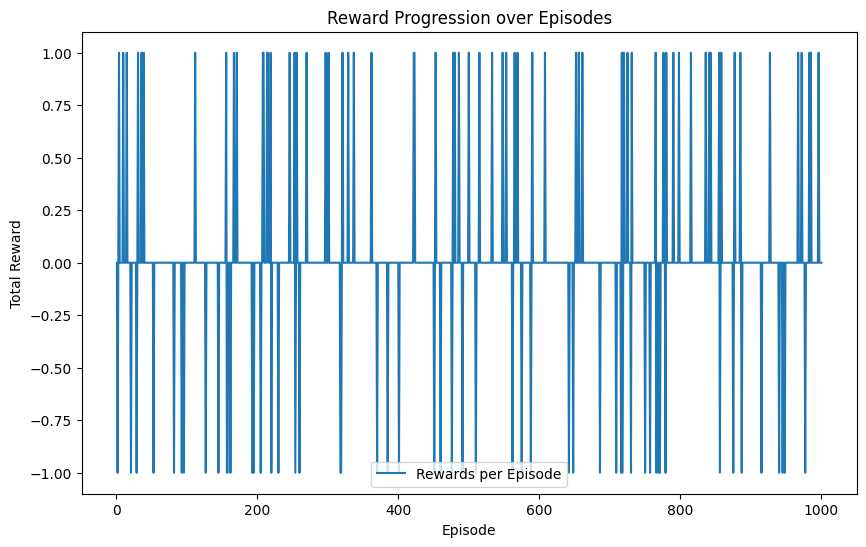

In [5]:

# Plotting the rewards
plt.figure(figsize=(10, 6))
plt.plot(episodes, reward_per_episode, label="Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Reward Progression over Episodes")
plt.legend()
plt.show()
